## Global Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import seed
seed(10)

## Load Data

In [2]:
!ls

Full_dataset_spd.csv  sample_data


In [3]:
fileName = 'Full_dataset_spd.csv'
dataset = pd.read_csv(fileName, header=None, engine='python')
dataset.shape

(26673, 57)

In [4]:
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-8.53,6.07,-7.55,-1.63,9.80,-2.71,-9.22,-8.53,-14.0,14.30,...,1.28,-2.86,-9.22,-3.77,-7.13,-15.3,3.27,-24.9,-2.86,1
1,-4.20,12.10,-2.51,-6.91,7.59,-7.44,-6.74,-4.20,-19.6,-21.50,...,1.02,-2.11,-6.74,22.60,-17.80,-19.9,-10.20,-25.0,-2.11,1
2,-2.81,1.98,3.66,2.62,10.90,-0.14,-8.79,-2.81,-18.2,4.21,...,4.55,-14.90,-8.79,-1.86,-9.69,-23.0,-4.15,-22.4,-14.90,1
3,-1.27,2.42,-2.27,3.12,12.40,-7.43,-4.10,-1.27,-17.5,-7.62,...,-9.13,-14.40,-4.10,6.81,-15.40,-21.7,9.28,-13.7,-14.40,1
4,-7.36,3.59,5.63,4.44,13.60,1.30,-13.20,-7.36,-22.4,-23.80,...,6.42,-9.81,-13.20,19.30,-15.00,-17.6,2.15,-24.7,-9.81,1


In [5]:
dataset.isnull().any().any()

False

In [6]:
dataset.fillna(1, inplace=True)

In [7]:
dataset.isnull().any().any()

False

In [8]:
shortCol = []
columns = dataset.columns.tolist()
for i in columns:
  if(dataset[i].nunique() != 1):
    shortCol.append(i)
    #print(i, ": ", dataset[i].nunique())

In [9]:
ttl_data = dataset.iloc[:, shortCol].values
np.random.shuffle(ttl_data)
ttl_data.shape

(26673, 57)

In [10]:
ttl_data[ttl_data[:, -1] == 1].shape

(12646, 57)

In [11]:
ttl_data[ttl_data[:, -1] == 0].shape

(14027, 57)

## Separate Positives & Negatives

In [12]:
pos = ttl_data[ttl_data[:, -1] == 1]
np.random.shuffle(pos)
neg = ttl_data[ttl_data[:, -1] == 0]
np.random.shuffle(neg)

## Train-Test Split

In [13]:
tstSize = 5335
p_test, p_train = pos[0:tstSize, ...], pos[tstSize:, ...]
n_test, n_train = neg[0:tstSize, ...], neg[tstSize:, ...]
train, test = np.vstack((p_train, n_train)), np.vstack((p_test, n_test))
np.random.shuffle(train)
np.random.shuffle(test)
X_train, X_test, y_train, y_test = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1]

In [14]:

print(y_train.shape)
print(y_train[y_train == 1].shape)
print(y_train[y_train == 0].shape)

print('-'*60)

print(y_test.shape)
print(y_test[y_test == 1].shape)
print(y_test[y_test == 0].shape)

(16003,)
(7311,)
(8692,)
------------------------------------------------------------
(10670,)
(5335,)
(5335,)


## Scaling Data

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Balance Data

In [16]:
### direct undersampling ###

# tstSize = 100
# p_test, p_train = pos[0:tstSize, ...], pos[tstSize:, ...]
# n_test, n_train = neg[0:tstSize, ...], neg[tstSize:tstSize+p_train.shape[0], ...]
# train, test = np.vstack((p_train, n_train)), np.vstack((p_test, n_test))
# np.random.shuffle(train)
# np.random.shuffle(test)
# X_train, X_test, y_train, y_test = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1]

In [17]:
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks(sampling_strategy='auto')
# #tl = TomekLinks(sampling_strategy='all')
# X_train_res, y_train_res = tl.fit_resample(X_train, y_train)

In [18]:
# from imblearn.over_sampling import SVMSMOTE
# X_train_res, y_train_res = SVMSMOTE().fit_resample(X_train_res, y_train_res)

In [19]:
# from imblearn.under_sampling import ClusterCentroids
# X_train_res, y_train_res = ClusterCentroids(sampling_strategy='auto').fit_resample(X_train, y_train)

In [20]:
from imblearn.combine import SMOTETomek
X_train_res, y_train_res = SMOTETomek(random_state=42).fit_resample(X_train, y_train)

In [21]:
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks(sampling_strategy='all')
# X_train_res, y_train_res = tl.fit_resample(X_train_res, y_train_res)

In [22]:
print(y_train_res.shape)
print(y_train_res[y_train_res == 1].shape)
print(y_train_res[y_train_res == 0].shape)

(16494,)
(8247,)
(8247,)


## Trial SVM


In [23]:
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

regr = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = SVC(kernel='rbf', C=1.0, gamma='scale')

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.6160262417994377

f1_score:  0.6229870249378854

Confusion Matrix
[[3188 2147]
 [1950 3385]]
------------------------------------------------------------
accuracy:  0.6060918462980318

f1_score:  0.6121620374642428

Confusion Matrix
[[3150 2185]
 [2018 3317]]


## XGBoost

In [24]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

regr = XGBRegressor(n_estimators=300)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

regr = XGBRFRegressor(n_estimators=300)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = XGBClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = XGBRFClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

[10:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
accuracy:  0.6181818181818182

f1_score:  0.6188961646398503

Confusion Matrix
[[3288 2047]
 [2027 3308]]
------------------------------------------------------------
[10:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
accuracy:  0.5735707591377694

f1_score:  0.5760342899739098

Confusion Matrix
[[3029 2306]
 [2244 3091]]
------------------------------------------------------------
accuracy:  0.6121836925960638

f1_score:  0.6121109861267342

Confusion Matrix
[[3267 2068]
 [2070 3265]]
------------------------------------------------------------
accuracy:  0.5731021555763823

f1_score:  0.5755288416736558

Confusion Matrix
[[3027 2308]
 [2247 3088]]


## AdaBoost

In [25]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(n_estimators=300)
boost.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.5731021555763823

f1_score:  0.5755288416736558

Confusion Matrix
[[3027 2308]
 [2247 3088]]


## RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=300)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=300)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.569821930646673

f1_score:  0.5554048818287485

Confusion Matrix
[[3213 2122]
 [2468 2867]]
------------------------------------------------------------
accuracy:  0.5705716963448922

f1_score:  0.5886155503681092

Confusion Matrix
[[2810 2525]
 [2057 3278]]


##MLP neural_network

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1, max_iter=1000)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
clf.fit(X_train, y_train)


from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.59454545 0.61939394 0.6        0.60242424 0.57246816 0.60703457
 0.59975743 0.61491813 0.62340813 0.62644027]
accuracy:  0.6060390319201719
0.015245260329340975


In [28]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.5882849109653233

f1_score:  0.5176238058636214

Confusion Matrix
[[3920 1415]
 [2978 2357]]


## LightGBM

In [29]:
from lightgbm import LGBMRegressor, LGBMClassifier

regr = LGBMRegressor(num_leaves=31, n_estimators=40, learning_rate=0.1)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.6186504217432053

f1_score:  0.6127343675644809

Confusion Matrix
[[3382 1953]
 [2116 3219]]
------------------------------------------------------------
accuracy:  0.6254920337394564

f1_score:  0.6211604095563141

Confusion Matrix
[[3398 1937]
 [2059 3276]]


In [30]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.6254920337394564

f1_score:  0.6211604095563141

Confusion Matrix
[[3398 1937]
 [2059 3276]]


##ExtraTrees

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.79515152 0.78787879 0.77575758 0.79878788 0.78289873 0.78411158
 0.77622802 0.79927229 0.82959369 0.85263796]
accuracy:  0.7982318025616995
0.023420940627615166


In [32]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.7373945641986879

f1_score:  0.7046795952782461

Confusion Matrix
[[4525  810]
 [1992 3343]]


##SVM

In [33]:
from sklearn.svm import SVC, SVR

classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
classifier.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.63212121 0.63818182 0.61878788 0.6169697  0.60764099 0.63978169
 0.60885385 0.63311098 0.64038811 0.66040024]
accuracy:  0.6296236470220703
0.01565266014688117


In [34]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.6060918462980318

f1_score:  0.6121620374642428

Confusion Matrix
[[3150 2185]
 [2018 3317]]


##XGBOOST

In [35]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

clf = XGBClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

print('-'*60)

clf = XGBRFClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())



***CROSS VALIDATION***
[0.62121212 0.64       0.6369697  0.62848485 0.62401455 0.63250455
 0.6185567  0.64402668 0.66767738 0.66100667]
accuracy:  0.6374453203961998
0.015571014963872245
------------------------------------------------------------
***CROSS VALIDATION***
[0.58363636 0.58181818 0.57636364 0.57515152 0.55912674 0.594906
 0.57368102 0.58762887 0.58641601 0.60157671]
accuracy:  0.5820305051730157
0.011290531395249064


In [36]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.5731021555763823

f1_score:  0.5755288416736558

Confusion Matrix
[[3027 2308]
 [2247 3088]]


##LightGBM

In [37]:
from lightgbm import LGBMRegressor, LGBMClassifier

clf = LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.63151515 0.64787879 0.64484848 0.63393939 0.62401455 0.6531231
 0.62098241 0.6531231  0.65858096 0.67738023]
accuracy:  0.6445386184464414
0.016408792144786636


In [38]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.6254920337394564

f1_score:  0.6211604095563141

Confusion Matrix
[[3398 1937]
 [2059 3276]]


## Init Scorers

In [39]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef
from imblearn.metrics import sensitivity_score, specificity_score

curves = []

def plt_curve(lst, name):
  plt.figure(figsize=(10,7))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
    
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

## SVM CV Scores

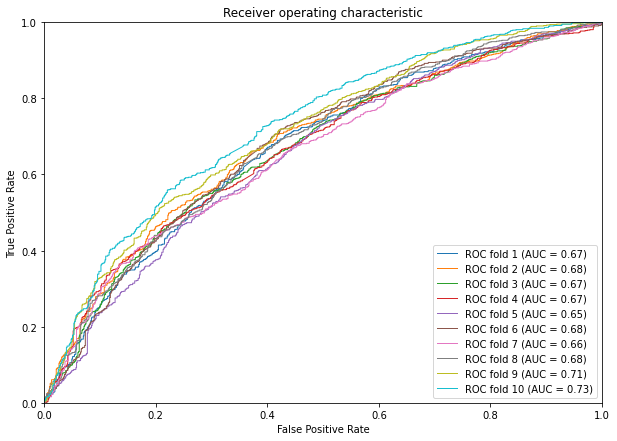

***CROSS VALIDATION***
SVM


{'fit_time': array([147.19855785, 149.42354083, 146.79496145, 147.63084722,
        162.31265616, 146.83500624, 134.63632321, 137.36797142,
        143.74512458, 143.23941851]),
 'score_time': array([4.50077319, 4.50671387, 4.60815859, 4.5198431 , 4.53187943,
        4.50839567, 4.49991965, 5.03507566, 4.53257799, 4.62721157]),
 'test_matthews_corrcoef': array([0.26424417, 0.27670555, 0.23810547, 0.23396415, 0.2153663 ,
        0.27979086, 0.21818913, 0.26624776, 0.28151528, 0.32090351]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_sensitivity_score': array([0.63393939, 0.6630303 , 0.65212121, 0.60969697, 0.59223301,
        0.65898058, 0.6407767 , 0.64121212, 0.67757576, 0.67393939]),
 'test_specificity_score': array([0.63030303, 0.61333333, 0.58545455, 0.62424242, 0.6230303 ,
        0.62060606, 0.5769697 , 0.625     , 0.60315534, 0.64684466])}

In [40]:
from sklearn.svm import SVC, SVR
classifier = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "SVM CV")
print("***CROSS VALIDATION***")
print("SVM")
scores
#scores['roc']=curves

## XGBoost CV Scores

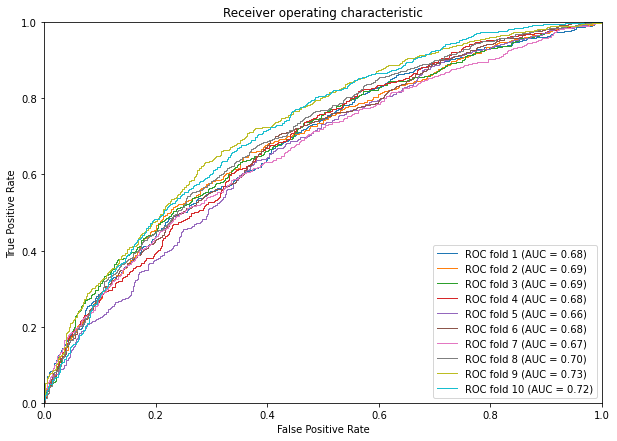

***CROSS VALIDATION***
XGBoost


{'fit_time': array([11.54473829, 11.54521537, 11.62317514, 11.56026173, 11.61013794,
        11.57725763, 12.05369687, 11.64959764, 11.16402268, 11.01968503]),
 'score_time': array([0.04578686, 0.04460144, 0.04411387, 0.04298711, 0.04606438,
        0.04458475, 0.0454042 , 0.04472351, 0.04604316, 0.04501081]),
 'test_matthews_corrcoef': array([0.24248856, 0.28004032, 0.27394121, 0.25697895, 0.24817658,
        0.26515475, 0.2371404 , 0.28808211, 0.33576994, 0.32207308]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_sensitivity_score': array([0.60969697, 0.63151515, 0.63878788, 0.62424242, 0.60558252,
        0.64805825, 0.625     , 0.65212121, 0.69333333, 0.67151515]),
 'test_specificity_score': array([0.63272727, 0.64848485, 0.63515152, 0.63272727, 0.64242424,
        0.6169697 , 0.61212121, 0.63592233, 0.64199029, 0.65048544])}

In [41]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
classifier = XGBClassifier(n_estimators=300)

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "XGBoost CV")
print("***CROSS VALIDATION***")
print("XGBoost")
scores
#scores['roc']=curves

## ET CV Scores

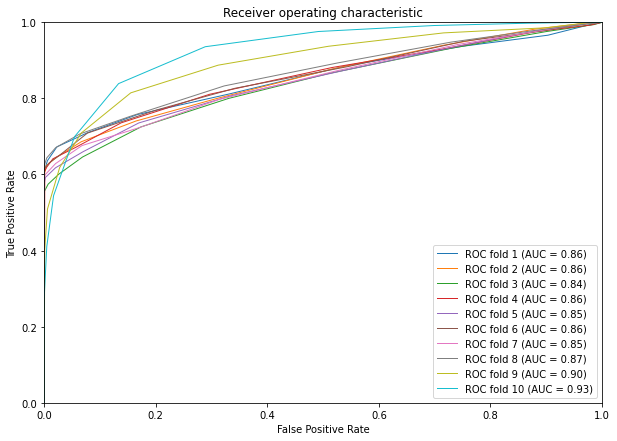

***CROSS VALIDATION***
ET


{'fit_time': array([0.31637263, 0.29562664, 0.2980814 , 0.28916526, 0.2849853 ,
        0.29156208, 0.28569341, 0.29774952, 0.28866339, 0.28819513]),
 'score_time': array([0.02412248, 0.02408791, 0.02211642, 0.02290034, 0.02291083,
        0.02336979, 0.02450728, 0.02246284, 0.02297568, 0.02262306]),
 'test_matthews_corrcoef': array([0.59197707, 0.57834826, 0.55439634, 0.60238123, 0.56832154,
        0.56845627, 0.55552896, 0.60119432, 0.65949675, 0.70555537]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_sensitivity_score': array([0.75757576, 0.74060606, 0.72484848, 0.73575758, 0.73543689,
        0.76941748, 0.72330097, 0.75272727, 0.81454545, 0.83878788]),
 'test_specificity_score': array([0.83272727, 0.83515152, 0.82666667, 0.86181818, 0.83030303,
        0.79878788, 0.82909091, 0.84587379, 0.84466019, 0.86650485])}

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "ET CV")
print("***CROSS VALIDATION***")
print("ET")
scores
#scores['roc']=curves

##MLP CV

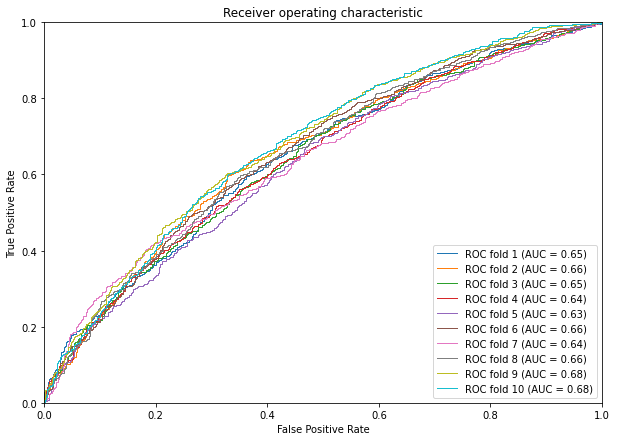

***CROSS VALIDATION***
MLP


{'fit_time': array([ 7.47693896,  6.66728711,  7.92307448,  8.11246037,  8.30320644,
        10.14148879, 11.27971196,  9.78914022, 12.9930563 ,  7.37097454]),
 'score_time': array([0.01413727, 0.01352215, 0.01993704, 0.01427412, 0.01297641,
        0.01349258, 0.01275969, 0.01271248, 0.01258922, 0.01267338]),
 'test_matthews_corrcoef': array([0.22121157, 0.24989697, 0.19529848, 0.20123711, 0.17893204,
        0.23121891, 0.18930403, 0.22139968, 0.24722584, 0.26508173]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_sensitivity_score': array([0.64727273, 0.64484848, 0.6169697 , 0.59272727, 0.5776699 ,
        0.63349515, 0.63592233, 0.6230303 , 0.65333333, 0.62181818]),
 'test_specificity_score': array([0.57333333, 0.60484848, 0.57818182, 0.60848485, 0.60121212,
        0.59757576, 0.55272727, 0.59830097, 0.5934466 , 0.64320388])}

In [43]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha=1, max_iter=1000)

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "MLP CV")
print("***CROSS VALIDATION***")
print("MLP")
scores
#scores['roc']=curves

## ROC Comparisons of all Estimators and Average Precision

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp

tprs = []
def plt_curve(lst, name):
  plt.figure(figsize=(10,7))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    tprs.append(interp(np.linspace(0, 1, 100), fpr, tpr))
    tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Random Guess', alpha=.8)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color='b',
         label='% fold cross validation (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

def pr_curve(lst, apLst, name):
  plt.figure(figsize=(10,7))
  
  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))
  
  for idx, itm in enumerate(lst):
    pre, rec = itm
    plt.plot(pre, rec, lw=2, label='Precision-Recall fold %d (AP = %0.2f)' % (idx+1, apLst[idx]))
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def pr_plt(y_true, y_score):
  precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
  pr_curves.append([precision, recall])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'pr_plt': make_scorer(pr_plt, needs_proba=True), 
         'average_precision': make_scorer(average_precision_score, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

***Independent Test***
matthews_corrcoef for SVM:  0.21228772422685818

sensitivity_score for SVM:  0.6217432052483599

specificity_score for SVM:  0.5904404873477038

***Independent Test***
matthews_corrcoef for XGBoost:  0.22436740095810562

sensitivity_score for XGBoost:  0.6119962511715089

specificity_score for XGBoost:  0.6123711340206186

***Independent Test***
matthews_corrcoef for ET:  0.486889449387449

sensitivity_score for ET:  0.6266166822867854

specificity_score for ET:  0.8481724461105904

***Independent Test***
matthews_corrcoef for MLP:  0.2000394885776215

sensitivity_score for MLP:  0.6099343955014058

specificity_score for MLP:  0.5900656044985942



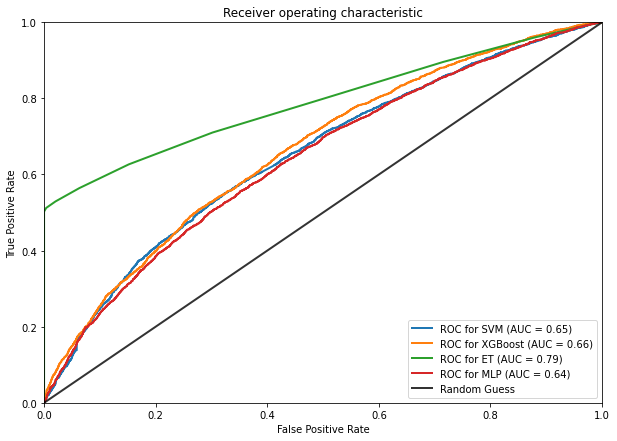

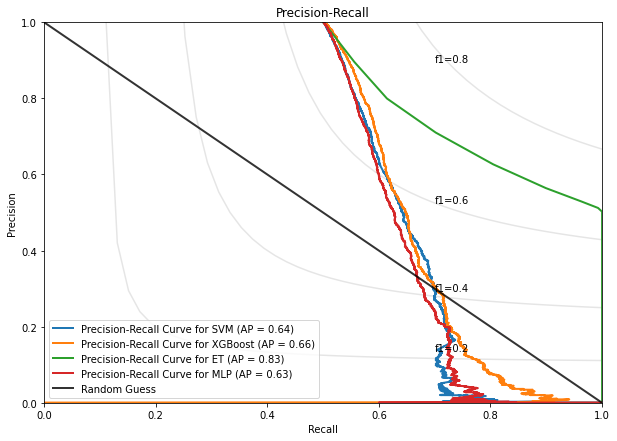

In [45]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier


estimators = {"SVM": SVC(kernel='rbf', probability=True, gamma='scale'),
              "XGBoost": XGBClassifier(n_estimators=300),
              "ET": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
              "MLP": MLPClassifier(alpha=1, max_iter=1000)}

probas_pred = []
avg_pre = []

plt.figure(figsize=(10,7))

for key, clf in estimators.items():
  clf.fit(X_train_res, y_train_res)
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)
  probas_pred.append(y_score)
  avg_pre.append(average_precision_score(y_test, y_score[:, 1], pos_label=1))

  fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
  
  plt.plot(fpr, tpr, lw=2, label='ROC for %s (AUC = %0.2f)' % (key, auc(fpr, tpr)))
  print("***Independent Test***")
  mat_cor_coef = matthews_corrcoef(y_test, y_pred)
  print("matthews_corrcoef for " + key + ": ", mat_cor_coef)
  print()

  sen_scr = sensitivity_score(y_test, y_pred)
  print("sensitivity_score for " + key + ": ", sen_scr)
  print()

  spe_scr = specificity_score(y_test, y_pred)
  print("specificity_score for " + key + ": ", spe_scr)
  print()
plt.plot([0, 1], [0, 1], linestyle='-', lw=2, color='black',
       label='Random Guess', alpha=.8)   
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
figName = "Compare_All_ROC" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,7))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
  x = np.linspace(0.01, 1)
  y = f_score * x / (2 * x - f_score)
  l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
  plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))

keyZ = list(estimators.keys())
for idx, y_score in enumerate(probas_pred):
  pre, rec, _ = precision_recall_curve(y_test, y_score[:, 1], pos_label=1)
  
  plt.plot(pre, rec, lw=2, label='Precision-Recall Curve for %s (AP = %0.2f)' % (keyZ[idx], avg_pre[idx]))
plt.plot([1, 0], [0, 1], linestyle='-', lw=2, color='black',
       label='Random Guess', alpha=.8)  
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc="lower left")
figName = "Compare_All_Precision-Recall" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()

## Cross Validation and Independent Test for (SVM)

In [63]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp
import numpy as np 

tprs = []
def plt_curve(lst, name):
  plt.figure(figsize=(10,7))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    tprs.append(interp(np.linspace(0, 1, 100), fpr, tpr))
    tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Random Guess', alpha=.8)

  mean_tpr = np.float64(1.0)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color='b',
         label='% fold cross validation (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

def pr_curve(lst, apLst, name):
  plt.figure(figsize=(10,7))
  
  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))
  
  for idx, itm in enumerate(lst):
    pre, rec = itm
    plt.plot(pre, rec, lw=1, label='Precision-Recall fold %d (AP = %0.2f)' % (idx+1, apLst[idx]))
    
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def pr_plt(y_true, y_score):
  precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
  pr_curves.append([precision, recall])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'pr_plt': make_scorer(pr_plt, needs_proba=True), 
         'average_precision': make_scorer(average_precision_score, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


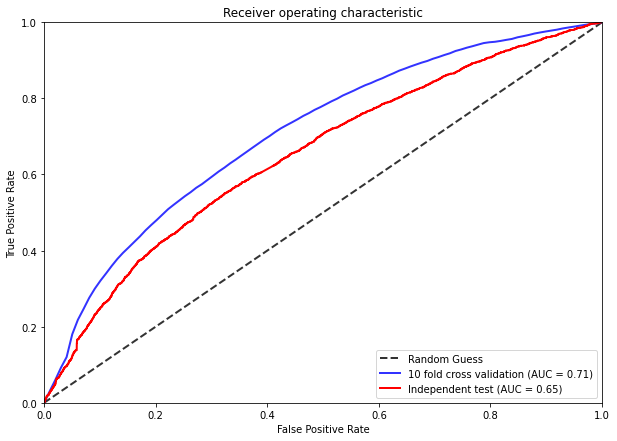

In [65]:
from sklearn.svm import SVC, SVR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
seed(10)
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets 

classifier = SVC(kernel='rbf', probability=True, gamma='scale')

curves = []
pr_curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=True)


tprs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,7))

for idx, itm in enumerate(curves):
  fpr, tpr = itm
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
       label='Random Guess', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
#mean_tpr[mean_tpr > 1] = 1

mean_auc = auc(mean_fpr, mean_tpr) 
plt.plot(mean_fpr, mean_tpr, color='b', label='10 fold cross validation (AUC = %0.2f)' % (mean_auc), lw=2, alpha=.8)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
plt.plot(fpr, tpr, lw=2, color='r', label='Independent test (AUC = %0.2f)' % (auc(fpr, tpr)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
figName = "SVM ROC(Cross val and Independent)" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()


##Cross Validation Curve

SVC
Accuracy: 62.8955 %
auROC: 0.680600
auPR: 0.6587
F1-score: 0.6342
MCC: 0.2581
Recall: 0.6434
Sensitivity (+): 64.3385 %
Specificity (-): 61.4526 %
Confusion Matrix:
[[5068 3179]
 [2941 5306]]
_______________________________________
XGBClassifier
Accuracy: 63.5080 %
auROC: 0.687889
auPR: 0.6777
F1-score: 0.6377
MCC: 0.2702
Recall: 0.6424
Sensitivity (+): 64.2415 %
Specificity (-): 62.7743 %
Confusion Matrix:
[[5177 3070]
 [2949 5298]]
_______________________________________
ExtraTreesClassifier
Accuracy: 79.7441 %
auROC: 0.862708
auPR: 0.8880
F1-score: 0.7895
MCC: 0.5967
Recall: 0.7598
Sensitivity (+): 75.9791 %
Specificity (-): 83.5092 %
Confusion Matrix:
[[6887 1360]
 [1981 6266]]
_______________________________________
MLPClassifier
Accuracy: 60.9070 %
auROC: 0.650400
auPR: 0.6414
F1-score: 0.6089
MCC: 0.2185
Recall: 0.6095
Sensitivity (+): 60.9555 %
Specificity (-): 60.8585 %
Confusion Matrix:
[[5019 3228]
 [3220 5027]]
_______________________________________


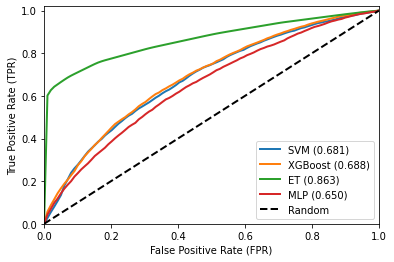

In [67]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp

def auROCplot():
    ### auROC ###
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    # plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    plt.savefig('cvAuROC.png', dpi=100)
    plt.show()
    ### --- ###

    
def runAll(X, y):
    Names = []
    Classifiers = []
    estimators = {"SVM": SVC(kernel='rbf', gamma='scale', probability=True),
                  "XGBoost": XGBClassifier(n_estimators=300),
                  "ET": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
                  "MLP": MLPClassifier(alpha=1, max_iter=1000)}

    for key, value in estimators.items():
        Names.append(key)
        Classifiers.append(value)

    Results = []  # compare algorithms

    from sklearn.metrics import accuracy_score, \
        confusion_matrix, \
        roc_auc_score,\
        average_precision_score,\
        roc_curve, f1_score, recall_score, matthews_corrcoef, auc

    # Step 05 : Spliting with 10-FCV :
    from sklearn.model_selection import StratifiedKFold

    cv = StratifiedKFold(n_splits=10, shuffle=True)

    for classifier, name in zip(Classifiers, Names):

        accuray = []
        auROC = []
        avePrecision = []
        F1_Score = []
        AUC = []
        MCC = []
        Recall = []

        mean_TPR = 0.0
        mean_FPR = np.linspace(0, 1, 100)

        CM = np.array([
            [0, 0],
            [0, 0],
        ], dtype=int)

        print(classifier.__class__.__name__)

        model = classifier
        for (train_index, test_index) in cv.split(X, y):

            X_train = X[train_index]
            X_test = X[test_index]

            y_train = y[train_index]
            y_test = y[test_index]

            model.fit(X_train, y_train)


            # Calculate ROC Curve and Area the Curve
            y_proba = model.predict_proba(X_test)[:, 1]
            FPR, TPR, _ = roc_curve(y_test, y_proba)
            mean_TPR += np.interp(mean_FPR, FPR, TPR)
            mean_TPR[0] = 0.0
            roc_auc = auc(FPR, TPR)
            ##########################################
            # print(FPR)
            # print(TPR)
            ##########################################

            y_artificial = model.predict(X_test)

            auROC.append(roc_auc_score(y_test, y_proba))

            accuray.append(accuracy_score(y_pred=y_artificial, y_true=y_test))
            avePrecision.append(average_precision_score(y_test, y_proba)) # auPR
            F1_Score.append(f1_score(y_true=y_test, y_pred=y_artificial))
            MCC.append(matthews_corrcoef(y_true=y_test, y_pred=y_artificial))
            Recall.append(recall_score(y_true=y_test, y_pred=y_artificial))
            AUC.append(roc_auc)

            CM += confusion_matrix(y_pred=y_artificial, y_true=y_test)

        accuray = [_*100.0 for _ in accuray]
        Results.append(accuray)

        mean_TPR /= cv.get_n_splits(X, y)
        mean_TPR[-1] = 1.0
        mean_auc = auc(mean_FPR, mean_TPR)
        plt.plot(
            mean_FPR,
            mean_TPR,
            linestyle='-',
            label='{} ({:0.3f})'.format(name, mean_auc), lw=2.0)

        print('Accuracy: {0:.4f} %'.format(np.mean(accuray)))
        # print('auROC: {0:.6f}'.format(np.mean(auROC)))
        print('auROC: {0:.6f}'.format(mean_auc))
        print('auPR: {0:.4f}'.format(np.mean(avePrecision))) # average_Precision
        print('F1-score: {0:.4f}'.format(np.mean(F1_Score)))
        print('MCC: {0:.4f}'.format(np.mean(MCC)))
        # print('average_AUC:', np.mean(AUC))
        # tn, fp, fn, tp = CM.ravel()
        TN, FP, FN, TP = CM.ravel()
        print('Recall: {0:.4f}'.format( np.mean(Recall)) )
        # print('AUC: {0:.4f}'.format( np.mean(AUC)) )
        print('Sensitivity (+): {0:.4f} %'.format( float( (TP) / (TP + FN) )*100.0 ))
        print('Specificity (-): {0:.4f} %'.format( float( (TN) / (TN + FP) )*100.0 ))
        print('Confusion Matrix:')
        print(CM)

        print('_______________________________________')

    ### auROC Curve ###
    auROCplot()

    
runAll(X_train_res, y_train_res)